## Capstone 1 
# San Francisco Bay Water Quality

ref. [Water quality of SF Bay home page](https://sfbay.wr.usgs.gov/access/wqdata/index.html)
     
     

## Unit 5 - Data Wrangling (phytoplankton data)

### Tasks

The first step in completing your capstone project is to collect data. Depending on your dataset, you may apply some of the data wrangling techniques that you learned in this unit.

Include answers to these questions in your submission:
   * What kind of cleaning steps did you perform?

   * How did you deal with missing values, if any?

   * Were there outliers, and how did you handle them?


## Phyoplankton Data

## Data Acquisition

#### Access
   1. Phytoplankton data downloaded from 
      1. [ScienceBase: Phytoplankton, 1992-2015](https://www.sciencebase.gov/catalog/item/5908f489e4b0fc4e448ffff1)
      2. [ScienceBase: Phytoplankton, 2016...](https://www.sciencebase.gov/catalog/item/598b755de4b09fa1cb0eadd9)
      
#### Files
   1. `Phytoplankton_San_Francisco_Bay_1992_2014.csv`
   1. `Phytoplankton_San_Francisco_Bay_2014_2016.csv`
   1. `Phytoplankton_San_Francisco_Bay_2017-2018.csv`
   
**Note**: The apparent overlap in dates for Phytoplankton files, `Phytoplankton_San_Francisco_Bay_1992_2014.csv` and `Phytoplankton_San_Francisco_Bay_2014_2016.csv`, is not an error. Data from the first three months of 2014 is included in two separate files.  Possible redundant 2014 rows will need to be investigated.

   
#### Data Format

All files are formatted as CSV (comma-separated values).
   

**Phytoplankton**

Phytoplankton files have one header row. Column headers include units of measure. These will be stripped.

<small>

```
Taxonomic Identification, Phylum or Class, Date,Station Number, Depth (m), Actual Count, Density (cells/mL), Biovolume (cubic micrometers/mL), Cell Volume (cubic micrometers/cell)
```
</small>

_Note: The `Actual Count` parameter was not included before 2014._ The recommendation from USGS is to not use this field, as it is essntially "for internal use only".




## Setup

Import libraries

In [1]:
# Import useful libraries

import csv
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from statistics import (median, mode)

## Read in the Phytoplankton data


### Issue: UnicodeDecodeError

While initially reading in the Phytoplankton data
```
ph_df1 = pd.read_csv('Data/orig/Phytoplankton_San_Francisco_Bay_1992_2014.csv', header=0)
```

I got an error:
<small>

```
UnicodeDecodeError                        Traceback (most recent call last)
<ipython-input-5-0cbe2ac6151a> in <module>
      1 # Read in Phytoplankton data
----> 2 ph_df1 = pd.read_csv('.../Phytoplankton_San_Francisco_Bay_1992_2014.csv', header=0)
...
UnicodeDecodeError 'utf-8' codec can't decode byte 0xa0 in position 13: invalid start byte
```
</small>

A  [web search](https://lmgtfy.com/?q=utf-8%27+codec+can%27t+decode+byte+0xa0+in+position&n=1)
tells me that this is due to file encoding. 

I can fix this easily by changing the data encoding of the input file (which is my preference in this case). However, for purposes of practicing data wrangling, I followed these steps [via Kaggle](https://www.kaggle.com/singhchauhan/data-cleaning-challenge-inconsistent-data-entry):
<small>

```
In [ ]: import chardet
# look at the first thousand bytes to guess the character encoding
with open('Data/Phytoplankton_San_Francisco_Bay_1992_2014.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(1000))

# check what the character encoding might be
print(result)

Out [ ]:
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
```
</small>

Unfortunately, 
```
ph_df1 = pd.read_csv('Data/orig/Phytoplankton_San_Francisco_Bay_1992_2014.csv', header=0, encoding='ascii')
```
failed differently.

More searching turned up [this comment](https://stackoverflow.com/questions/21129020/how-to-fix-unicodedecodeerror-ascii-codec-cant-decode-byte/21129492#comment67359759_21129492).

so I tried 
```
ph_df1 = pd.read_csv('Data/orig/Phytoplankton_San_Francisco_Bay_1992_2014.csv', header=0, encoding='latin1')
```

which worked and did not throw any errors.

**Note:** Now that I understand encoding a bit more, I fixed the encoding of the CSV files on disk to be UTF8.

In [2]:
# Read in Phytoplankton data
# Files have been encoded as UTF8 on disk
ph_df1 = pd.read_csv('Data/orig/Phytoplankton_San_Francisco_Bay_1992_2014.csv', parse_dates=['Date'], header=0)
ph_df2 = pd.read_csv('Data/orig/Phytoplankton_San_Francisco_Bay_2014_2016.csv', parse_dates=['Date'], header=0)
ph_df3 = pd.read_csv('Data/orig/Phytoplankton_San_Francisco_Bay_2017-2018.csv', parse_dates=['Date'], header=0)

### Combine Phytoplankton datasets

Now we repeat the concatenation process with the Phytoplankton datasets, to get one combined DataFrame.
datasets


### Issue: mis-aligned columns

As noted before, one of the Phytoplankton datasets does not contain the `Actual Count` column. Thus, if we simply try a concatenation, 

```
ph_df = pd.concat([ph_df1, ph_df2, ph_df3]).reset_index(drop=True)
```

we'll get an error:

```
/Local/Users/vlb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.
```

Setting `sort=True` aligns the columns-in-common, allowing concatenation with the newer column not causing problems.

In [3]:
# Concatenate phytoplankton DataFrames
# sort=True ensures that columns are aligned.
ph_df = pd.concat([ph_df1, ph_df2, ph_df3], sort=True).reset_index(drop=True)

### Issue - possibly redundant records

Looking at the phytoplankton dataset filenames (and the first hundred rows of data), I was concerned that there might be overlap for part of 2014. An "overlapping" row would match on every field except for `Actual Count` which would be either a number or `NaN`. 

I examined some of the 2014 data, using:

```
ph_2014_df = ph_df.loc[ph_df['Date'].str.match('[12]/.*/2014')]

ph_2014_df.sort_values(by=['Date', 'Station Number', 'Depth (m)', 'Density (cells/mL)'])
```

I did not see any clear overlap. 

Sample:<br />
<img src="http://wiki.cfcl.com/pub/Vicki/Datasci/Capstone1DataWrangling/Check_for_Overlap_in-2014_phytoplanton_data.png" width="894" height="622">


We can now ignore the original phytoplankton files / DFs and use the concatenated DF containing all data from 1992 to 2018.

In [4]:
# Quick look at the phytoplankton DataFrame
ph_df.head()

,Actual Count,Biovolume (cubic micrometers/mL),Cell Volume (cubic micrometers/cell),Date,Density (cells/mL),Depth (m),Phylum or Class,Station Number,Taxonomic Identification
0,NaN,47502.0,5655.0,1992-04-01,8.4,1.0,BACILLARIOPHYTA,30.0,Asterionellopsis glacialis
1,NaN,950.6,58.3,1992-04-01,16.3,1.0,BACILLARIOPHYTA,30.0,Ceratoneis closterium
2,NaN,307827.0,1052.4,1992-04-01,292.5,1.0,BACILLARIOPHYTA,30.0,Chaetoceros debilis
3,NaN,476403.6,476403.6,1992-04-01,1.0,1.0,BACILLARIOPHYTA,30.0,Coscinodiscus radiatus
4,NaN,21122.2,157.6,1992-04-01,134.0,1.0,BACILLARIOPHYTA,30.0,Cyclotella sp.


### Alphabetical Ordering of Columns

Due to the need to sort columns before concatenation, the data columns are now in alphabetical order, left to right.

Before saving, I want to re-order the columns, to move Date, Station number, and Depth to the front. 

In [5]:
# Capture the list of columns
ph_df.columns

Index(['Actual Count', 'Biovolume (cubic micrometers/mL)',
       'Cell Volume (cubic micrometers/cell)', 'Date', 'Density (cells/mL)',
       'Depth (m)', 'Phylum or Class', 'Station Number',
       'Taxonomic Identification'],
      dtype='object')

In [6]:
# re-order the columns
ph_df = ph_df[['Date', 'Station Number', 'Depth (m)', 
               'Actual Count', 'Biovolume (cubic micrometers/mL)', 
               'Cell Volume (cubic micrometers/cell)', 'Density (cells/mL)',
               'Phylum or Class', 'Taxonomic Identification']]


In [7]:
# Create a units dictionary for phytoplankton

ph_units = {
 'Date': 'YYYY-MM-DD',
 'Station Number' : '', 
 'Depth': '(m)', 
 'Actual Count': '', 
 'Biovolume': '(cubic micrometers/mL)', 
 'Cell Volume': '(cubic micrometers/cell)', 
 'Density': '(cells/mL)',
 'Phylum or Class': '', 
 'Taxonomic Identification': ''
}

In [8]:
# Simplify the column names, removing units
ph_df.columns = ['Date', 'Station Number', 'Depth', 
               'Actual Count', 'Biovolume', 'Cell Volume', 'Density',
               'Phylum or Class', 'Taxonomic Identification']

Convert Station numbers to strings and remove unnecessary trailing .0

In [9]:
ph_df['Station Number'] = ph_df['Station Number'].astype(str)
ph_df['Station Number'] = [x.replace('.0', '') for x in ph_df['Station Number']]


<hr style="border: 5px solid green;">

## Examine Phytoplankton Data

In [10]:
ph_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33185 entries, 0 to 33184
Data columns (total 9 columns):
Date                        33185 non-null datetime64[ns]
Station Number              33185 non-null object
Depth                       33185 non-null float64
Actual Count                16743 non-null float64
Biovolume                   33185 non-null float64
Cell Volume                 33185 non-null float64
Density                     33185 non-null float64
Phylum or Class             33185 non-null object
Taxonomic Identification    33185 non-null object
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 2.3+ MB


The only missing data is in the `Actual Count` column. This value was not part of the dataset before 2014.

Note that pandas recognizes the Date field as a datetime object.

In [11]:
# Look at the portion of the Phytoplankton DataFrame 
# where Actual count is not null.
ph_counted_df = ph_df.loc[ph_df['Actual Count'].notnull()].sort_values('Date').reset_index(drop=True)
                                  
ph_counted_df.head(20)

,Date,Station Number,Depth,Actual Count,Biovolume,Cell Volume,Density,Phylum or Class,Taxonomic Identification
0,2014-01-14,6,2.0,1.0,78746.8,2944.9,26.7,BACILLARIOPHYTA,Actinocyclus sp.
1,2014-01-14,657,2.0,5.0,89596.4,1005.3,89.1,BACILLARIOPHYTA,Cyclotella sp.
2,2014-01-14,657,2.0,1.0,8238.0,2269.4,3.6,BACILLARIOPHYTA,Cyclotella striata
3,2014-01-14,657,2.0,2.0,3994.2,112.0,35.7,BACILLARIOPHYTA,Encyonema sp.
4,2014-01-14,657,2.0,7.0,439022.2,3518.7,124.8,BACILLARIOPHYTA,Entomoneis paludosa
5,2014-01-14,657,2.0,2.0,5230.6,720.5,7.3,BACILLARIOPHYTA,Epithemia sp.
6,2014-01-14,657,2.0,1.0,86264.5,4840.9,17.8,BACILLARIOPHYTA,Frustulia sp.
7,2014-01-14,657,2.0,1.0,745.7,41.8,17.8,BACILLARIOPHYTA,Gomphonema sp.
8,2014-01-14,657,2.0,1.0,11386.0,3136.6,3.6,BACILLARIOPHYTA,Gyrosigma fasciola
9,2014-01-14,657,2.0,1.0,2584.9,145.1,17.8,BACILLARIOPHYTA,Halamphora sp.


It appears that phytoplankton samples are typically only taken near the surface (e.g. 1 - 2 m depth). This makes sense; here's more light nearer the surface and phytoplankton need light.

Also, each record appears to apply to a different Genus/species of phytoplankton. 

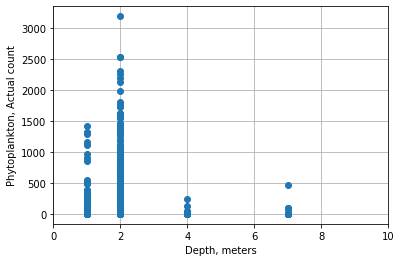

In [12]:
# Phytoplankton, actual count by depth

ph_tmp_df = ph_counted_df.loc[:,['Depth', 'Actual Count']
                       ].sort_values('Depth'
                       ).reindex()

ax = ph_tmp_df.plot(x='Depth', linestyle='none', marker='o', legend=False)

# Set the x-axis label
ax.set_xlabel("Depth, meters")

# Set the y-axis label
ax.set_ylabel("Phytoplankton, Actual count")

ax.grid(True)
# ax.set_xticklabels([], minor=True)

plt.xlim(0,10)
plt.show()

Although "Actual Count" is only made at shallower levels, Density (cells/ml) has been sampled at deeper volumns, including samples taken between 34 and 36 meters.

(I checked before setting the xticks; there is no data beyond 40 meters.)


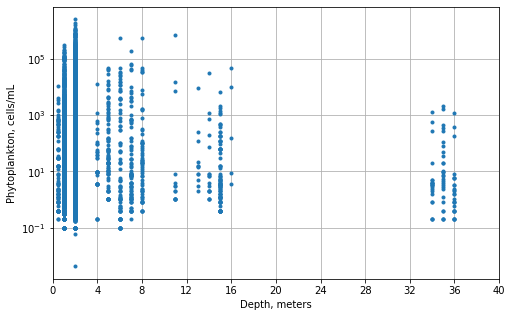

In [13]:
# Phytoplankton, density by depth, full dataset, with and without Actual Count

ph_tmp_df = ph_df.loc[:,['Depth', 'Density']
                       ].sort_values('Depth'
                       ).reindex()

xticks=(range(0,41,4))
ax = ph_tmp_df.plot(x='Depth', linestyle='none', marker='.', logy=True, 
                    figsize=(8,5), legend=False, xticks=xticks)

# Set the x-axis label
ax.set_xlabel("Depth, meters")

# Set the y-axis label
ax.set_ylabel("Phytoplankton, cells/mL")

ax.grid(True)

plt.show()

Density has not been measured at deeper levels in post-2014 samples.

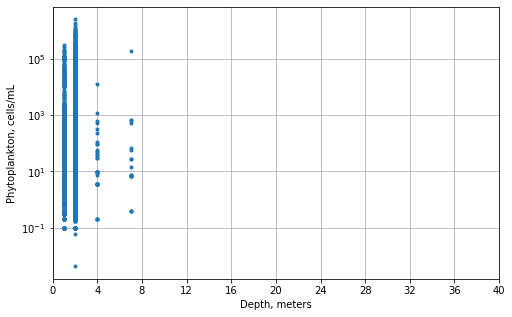

In [14]:
# Phytoplankton, density by depth, post-2014 dataset 
# (Actual count != null)

ph_tmp_df = ph_counted_df.loc[:,['Depth', 'Density']
                       ].sort_values('Depth'
                       ).reindex()

xticks=(range(0,41,4))
ax = ph_tmp_df.plot(x='Depth', linestyle='none', marker='.', 
                    figsize=(8,5), logy=True, legend=False, xticks=xticks)

# Set the x-axis label
ax.set_xlabel("Depth, meters")

# Set the y-axis label
ax.set_ylabel("Phytoplankton, cells/mL")

ax.grid(True)

plt.show()


## Issue: Actual Count values are unexpected

`Actual count` is described as "Number of phytoplankton cells counted in the sample". Sample size has not been provided.

`Density` is described as "Number of phytoplankton cells per milliliter of water."

`Actual count` values seem to be at odds with `Density` values. Most "actual counts" are very small; the mean is 25 cells. But density is much larger; the mean is 2803.


In [15]:
# In the portion of the dataset where Actual Count has been included
ph_counted_df['Actual Count'].describe() 

count    16743.000000
mean        25.164845
std        113.539136
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max       3195.000000
Name: Actual Count, dtype: float64

In [16]:
print("median Actual Count:", median(ph_counted_df['Actual Count']))
print("mode:", mode(ph_counted_df['Actual Count']))

median Actual Count: 2.0
mode: 1.0


I asked my USGS contact. Her recommendation is that I ignore the `Actual Count` field. 
   * it's primarily a "notation" field; someone saw these cells under a microscope
   * the sample size is indeterminable
   * it's unrelated to the rest of the data
   
I will remove this column

In [17]:
ph_df.drop(columns=['Actual Count'], inplace=True)

del ph_units['Actual Count']

### Question - if Density is low but Cell Volume is high, are these huge cells?

Again, I asked my USGS contact, who confirmed. Her recommendation is to concentrate on Biovolume, ignoring Density and Cell Volume.

In [18]:
ph_df.drop(columns=['Density', 'Cell Volume'], inplace=True)

del ph_units['Density']
del ph_units['Cell Volume']

In [19]:
ph_df.sample(10)

,Date,Station Number,Depth,Biovolume,Phylum or Class,Taxonomic Identification
12843,2008-08-19,18,2.0,511.30000,DINOPHYCEAE,Amphidinium sphenoides
30997,2018-05-07,657,2.0,646.12763,BACILLARIOPHYTA,Unknown Diatom
21448,2015-10-15,657,2.0,14335.40000,CHLOROPHYTA,Chlamydomonas globosa
11261,2006-08-02,21,2.0,3298.60000,RAPHIDOPHYCEAE,Heterosigma akashiwo
1700,1994-02-17,32,2.0,2585.70000,BACILLARIOPHYTA,Gyrosigma fasciola
22091,2016-01-21,36,1.0,12935.50000,BACILLARIOPHYTA,Tryblionella compressa
8214,2002-04-22,32,2.0,250.00000,CYANOPHYCEAE,Synechocystis sp.
14773,2011-06-24,24,2.0,351603.00000,BACILLARIOPHYTA,Thalassiosira visurgis
6713,2000-03-29,30,2.0,171837.10000,BACILLARIOPHYTA,Skeletonema costatum
5963,1999-03-09,657,2.0,44962.60000,CRYPTOPHYTA,Plagioselmis prolonga


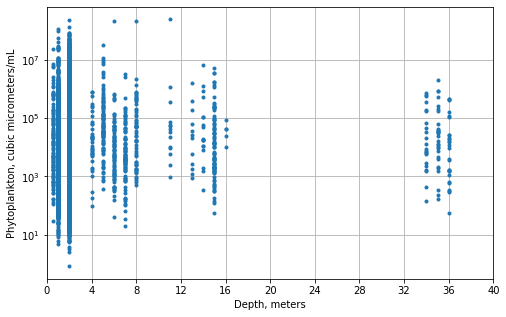

In [20]:
# Phytoplankton, density by depth, full dataset, with and without Actual Count

ph_tmp_df = ph_df.loc[:,['Depth', 'Biovolume']
                       ].sort_values('Depth'
                       ).reindex()

xticks=(range(0,41,4))
ax = ph_tmp_df.plot(x='Depth', linestyle='none', marker='.', logy=True, 
                    figsize=(8,5), legend=False, xticks=xticks)

# Set the x-axis label
ax.set_xlabel("Depth, meters")

# Set the y-axis label
ax.set_ylabel("Phytoplankton, cubic micrometers/mL")

ax.grid(True)

plt.show()

### Save Phytoplankton DataFrame to disk


In [21]:
# Save our work
ph_df.to_csv('Data/Phytoplankton.csv', index=False)

Review first two lines of the new file on disk
<small>
    
```
Date,Station Number,Depth,Biovolume,Phylum or Class,Taxonomic Identification
1992-04-01,30,1.0,47502.0,BACILLARIOPHYTA,Asterionellopsis glacialis
```
</small>

We can read the data back in with 
```
ph_df = pd.read_csv('Data/Phytoplankton.csv', 
                     header=0, 
                     parse_dates=['Date'],
                     dtype={'Station Number' : str}
```